# Google News scraping with the GNews package

## Environment set-up and getting the company sample from the sustainability reports

In [75]:
from gnews import GNews
from newspaper import Article
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import requests
import os
import spacy
from tqdm import tqdm

In [33]:
os.getcwd()

'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_pre-processing'

In [34]:
path_reports = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data\\reports'

In [35]:
sample = os.listdir(path_reports)

In [36]:
# converting to panda series because I find it easier to manipulate
company_list = [word.split('.')[0] for word in sample]
company_list = pd.Series(company_list)

In [58]:
list(company_list)

['abb',
 'adidas',
 'airbus',
 'apple',
 'bayer',
 'beiersdorf',
 'blackrock',
 'bmw',
 'boeing',
 'cemex',
 'chevron',
 'chipotle',
 'citi',
 'coca-cola',
 'colgate',
 'danone',
 'dell',
 'dhl',
 'diageo',
 'dupont',
 'edp',
 'enel',
 'eversource',
 'exxon',
 'ford-motor',
 'general-mills',
 'google',
 'h&m',
 'henkel',
 'hershey',
 'honda',
 'hp',
 'hyundai',
 'ibm',
 'inditex',
 'intel',
 'komatsu',
 'linde',
 'mcdonald',
 'mercedes',
 'microsoft',
 'mitsubishi',
 'mondelez',
 'nestle',
 'nextera',
 'nike',
 'p&g',
 'pepsico',
 'ralph-lauren',
 'renault',
 'rio-tinto',
 'schneider-electric',
 'shell',
 'sonoco',
 'starbucks',
 'tesco',
 'tesla',
 'totalenergies',
 'toyota',
 'veolia',
 'volkswagen',
 'volvo',
 'walmart']

We're planning to use these company names in the Google News search engine. First, to do that though, we need to replace the ampersand character with '%26' so that the search engine can read it as an ampersand character - this only applies to P&G and H&M. 

In [37]:
search_list = pd.Series(company_list)
search_list = search_list.str.replace('&','%26')

In [38]:
list(search_list)

['abb',
 'adidas',
 'airbus',
 'apple',
 'bayer',
 'beiersdorf',
 'blackrock',
 'bmw',
 'boeing',
 'cemex',
 'chevron',
 'chipotle',
 'citi',
 'coca-cola',
 'colgate',
 'danone',
 'dell',
 'dhl',
 'diageo',
 'dupont',
 'edp',
 'enel',
 'eversource',
 'exxon',
 'ford-motor',
 'general-mills',
 'google',
 'h%26m',
 'henkel',
 'hershey',
 'honda',
 'hp',
 'hyundai',
 'ibm',
 'inditex',
 'intel',
 'komatsu',
 'linde',
 'mcdonald',
 'mercedes',
 'microsoft',
 'mitsubishi',
 'mondelez',
 'nestle',
 'nextera',
 'nike',
 'p%26g',
 'pepsico',
 'ralph-lauren',
 'renault',
 'rio-tinto',
 'schneider-electric',
 'shell',
 'sonoco',
 'starbucks',
 'tesco',
 'tesla',
 'totalenergies',
 'toyota',
 'veolia',
 'volkswagen',
 'volvo',
 'walmart']

I also go ahead here and change the names of the companies here so that I can use it when excluding publisher names - see below. This is subject to change based on what kind of websites companies use to share news.

In [39]:
publisher_list = company_list.str.replace('-',' ') #so make it two words
publisher_list = publisher_list.str.replace('ford motor', 'ford')
publisher_list = publisher_list.str.replace('p&g', 'procter')
publisher_list

0            abb
1         adidas
2         airbus
3          apple
4          bayer
         ...    
58        toyota
59        veolia
60    volkswagen
61         volvo
62       walmart
Length: 63, dtype: object

In [40]:
list(publisher_list)

['abb',
 'adidas',
 'airbus',
 'apple',
 'bayer',
 'beiersdorf',
 'blackrock',
 'bmw',
 'boeing',
 'cemex',
 'chevron',
 'chipotle',
 'citi',
 'coca cola',
 'colgate',
 'danone',
 'dell',
 'dhl',
 'diageo',
 'dupont',
 'edp',
 'enel',
 'eversource',
 'exxon',
 'ford',
 'general mills',
 'google',
 'h&m',
 'henkel',
 'hershey',
 'honda',
 'hp',
 'hyundai',
 'ibm',
 'inditex',
 'intel',
 'komatsu',
 'linde',
 'mcdonald',
 'mercedes',
 'microsoft',
 'mitsubishi',
 'mondelez',
 'nestle',
 'nextera',
 'nike',
 'procter',
 'pepsico',
 'ralph lauren',
 'renault',
 'rio tinto',
 'schneider electric',
 'shell',
 'sonoco',
 'starbucks',
 'tesco',
 'tesla',
 'totalenergies',
 'toyota',
 'veolia',
 'volkswagen',
 'volvo',
 'walmart']

**To-do list for pre-processing/collection:**
1. Get a list of the companies and company names through the sustainability reports - make the name of the files the same as the search term used
2. Create a list of keywords for detecting sustainability/climate relatedness - stem them first possibly - think I should already have this or we can create them based on clustering/top keywords from the sustainability report 
3. Run the code for all the companies in the list in gnews (allintitle) - check if the number of articles is larger than 20 - if not:
     a. run it for intitle and concatenate the dataframes
4. Get rid of articles from the company itself 
5. Get the full article title and text
6. Get rid of articles with unrelevant titles/where webscraping is not possible - using 2 

## Creating a search loop on Google News - let's pray my IP doesn't get blocked

First, I define the GNews object - we search through English news, which are published after the 1st January 2021. This does have an effect of limiting results and for further research it might be useful to expand this to different languages and implement translation.

In [2]:
gn = GNews(language = 'en')
#gn.start_date = (2021,1,1)
#gn.exclude_websites = ['www.coca-colacompany.com'] #doesn't work as I would want it to - it generates the list of entries first and then removes them afterwards

Now I code the raw function to loop over the different companies and get the results. For starters let's just limit this to the first 10 companies in the list. 

**Idea**: I can do multiple searches with different keywords every time and then join it.

In [11]:
# full_df = pd.DataFrame()
# for idx,company in enumerate(search_list[:10]):
#     # generate search results - form of a dictionary
#     search = gn.get_news(f'allintitle:{company} sustainability OR climate OR environment OR pollution OR emission OR solar OR recycle OR wind OR plastic OR deforestation OR greenhouse OR waste OR biodiversity OR renewable after:2021-01-01') # for some reason this doesn't work that well if we include renewable/pollution - includes articles from before 2021
#     # create a temporary data frame from search results
#     temp_df = pd.DataFrame.from_dict(search)
#     # get publisher link and name from the publisher column
#     temp_df['publisher_link'] = temp_df['publisher'].apply(lambda x: x['href'])
#     temp_df['publisher_name'] = temp_df['publisher'].apply(lambda x: x['title'])
#     temp_df.drop(['description','publisher'], axis = 1, inplace = True)
#     # removing the publisher if the publisher is the company itself by creating a filter that checks for whether the company name is in the publisher name
#     company_filter = []
#     for i in range(len(temp_df)):
#         if (publisher_list[idx] in temp_df['publisher_name'][i].lower())|(publisher_list[idx] in temp_df['publisher_link'][i].lower()):
#             company_filter.append(False)
#         else:
#             company_filter.append(True)
#     temp_df = temp_df[company_filter]
#     # check length and run another search with intitle if too small (< 20) and repeat all the above steps
#     if len(temp_df) < 20:
#         search_second = gn.get_news(f'intitle:{company} sustainability OR climate OR environment OR pollution OR emission OR solar OR recycle OR wind OR plastic OR deforestation OR greenhouse OR waste OR biodiversity OR renewable after:2021-01-01')
#         temp_df_second = pd.DataFrame.from_dict(search_second)
#         temp_df_second['publisher_link'] = temp_df_second['publisher'].apply(lambda x: x['href'])
#         temp_df_second['publisher_name'] = temp_df_second['publisher'].apply(lambda x: x['title'])
#         temp_df_second.drop(['description','publisher'], axis = 1, inplace = True)
#         company_filter = []
#         for i in range(len(temp_df_second)):
#             if (publisher_list[idx] in temp_df_second['publisher_name'][i].lower())|(publisher_list[idx] in temp_df_second['publisher_link'][i].lower()):
#                 company_filter.append(False)
#             else:
#                 company_filter.append(True)
#         temp_df_second = temp_df_second[company_filter]
#         # concatenate the two dataframes into one dataframe
#         temp_df = pd.concat([temp_df,temp_df_second])
#     # remove any duplicates in temp_df
#     temp_df.drop_duplicates(subset = ['title'], inplace = True)
#     # add the company name as a column
#     temp_df['company'] = company_list[idx]
#     # add the temporary df to our full df
#     full_df = pd.concat([full_df, temp_df])

In [11]:
##creating a function to filter publishers so as to not include the companies themselves
def filter_publisher(publisher,df):
    company_filter = []
    for i in range(len(df)):
        if (publisher in df['publisher_name'][i].lower())|(publisher in df['publisher_link'][i].lower()):
            company_filter.append(False)
        else:
            company_filter.append(True)
    return df[company_filter]

In [136]:
# # creating a function to filter columns based on keywords
def filter_on_column(keywords,df,column):
    # creating a regex pattern
    pattern = '|'.join(list(set(keywords)))
    # creating the masking filter 
    masking = []
    for string in column:
        if re.search(pattern,string.lower()):
            masking.append(True)
        else: 
            masking.append(False)
    return df[masking]

In [135]:
# # creating a function to filter columns based on keywords
def filter_out_column(keywords,df,column):
    # creating a regex pattern
    pattern = '|'.join(list(set(keywords)))
    # creating the masking filter 
    masking = []
    for string in column:
        if re.search(pattern,string.lower()):
            masking.append(False)
        else: 
            masking.append(True)
    return df[masking]

In [74]:
full_df = pd.DataFrame()
for idx,company in enumerate(search_list[:30]):
    # generate search results - form of a dictionary
    # run three different searches due to Google News having a limit of 100 articles and too many keywords cause the search function to act strangely
    # search_1 = gn.get_news(f'intitle:{company} sustainability OR climate OR environment OR pollution OR emission OR solar OR recycle after:2021-01-01')
    # search_2 = gn.get_news(f'intitle:{company} wind OR plastic OR deforestation OR greenhouse OR waste OR biodiversity OR renewable after:2021-01-01')
    # search_3 = gn.get_news(f'intitle:{company} reusable OR biodegradable OR circular OR CO2 OR ecology OR ecosystem OR greenwash after:2021-01-01')
    search_1 = gn.get_news(f'allintitle:{company} sustainability OR sustainable OR climate OR environment OR environmental OR pollution OR pollute OR emission OR solar OR recycle OR recycling after:2021-01-01')
    search_2 = gn.get_news(f'allintitle:{company} emissions OR recycles OR recycled OR pollutes OR polluted OR polluting OR wind OR plastic OR deforestation OR greenhouse OR waste OR biodiversity OR renewable after:2021-01-01')
    search_3 = gn.get_news(f'allintitle:{company} reusing OR reuse OR reused OR reuses OR reusable OR biodegradable OR circular OR CO2 OR ecology OR ecological OR ecosystem OR greenwash OR greenwashing after:2021-01-01')
    search = search_1 + search_2 + search_3
    # create a temporary data frame from search results
    temp_df = pd.DataFrame.from_dict(search)
    # get publisher link and name from the publisher column
    temp_df['publisher_link'] = temp_df['publisher'].apply(lambda x: x['href'])
    temp_df['publisher_name'] = temp_df['publisher'].apply(lambda x: x['title'])
    temp_df.drop(['description','publisher'], axis = 1, inplace = True)
    # removing the publisher if the publisher is the company itself by creating a filter that checks for whether the company name is in the publisher name
    temp_df = filter_publisher(publisher_list[idx],temp_df)
    # remove any duplicates in temp_df
    temp_df.drop_duplicates(subset = ['title'], inplace = True)
    # add the company name as a column
    temp_df['company'] = company_list[idx]
    # add the temporary df to our full df
    full_df = pd.concat([full_df, temp_df])

In [ ]:
#'-'.join(filtered_temp['title'].str.split('-')[21][:-1])

### Extra - generating keywords to possibly use for filtering (tests)

In [ ]:
# keywords = ('ap', 'banana', 'orange')
# teststring = (
#     'this is a test string it contains apple. ',
#     'Moreover, this i a very long string contact length more than 500k'
# )
# testring2 = (
#     'this is a test string it contains apple, orange & banana. ',
#     'this is a test string it contains apple, orange & banana.'
# )
 
# # This is any
# pattern = '|'.join(keywords)

In [ ]:
# masking = []
# for idx, string in enumerate(teststring):
#     if re.search(pattern,string):
#         masking.append(True)
#     else:
#         masking.append(False)
    
# masking

In [ ]:
# # trying lemmatization
# lemmatizer = WordNetLemmatizer()
# lemmatized_sust = [lemmatizer.lemmatize(word) for word in sust_keywords]
# lemmatized_sust

In [ ]:
# non_company_filter = [not elem for elem in company_filter]

In [ ]:
# df_testing = pd.DataFrame()
# df_testing['x'] = [1,2]
# df_testing['y'] = [3,4]

In [ ]:
# df_coca['published date'] = pd.to_datetime(df_coca['published date'])
# df_coca['published_year'] = df_coca['published date'].dt.year

## Getting the full article texts and full article titles

I also want to filter these results so that it only includes articles that are climate/environment related. We can do this with the help of keywords possibly. One way is to get the list of keywords straight from the sustainability reports. Another is to create our own keyword list. 
 
A combination of both is also possible. For example, there is most likley not going to be the word greenwashing in the sustainability reports but the articles might mention it. We first need to get the full titles and texts.

In [102]:
# %%capture
# text_lst = []
# title_lst = []
# for link in full_df['url'][2000:]:
#     try:
#         article = gn.get_full_article(link)
#         text_lst.append(article.text)
#         title_lst.append(article.title)
#     except:
#         text_lst.append('webscraping not possible')
#         title_lst.append('webscraping not possible')
# full_df['text'] = text_lst
# full_df['title_full'] = title_lst

In [109]:
full_df.reset_index(inplace=True, drop=True)

In [121]:
full_df2['company'].value_counts()

shell                 200
tesco                 198
microsoft             195
walmart               195
tesla                 189
toyota                182
mcdonald              174
totalenergies         170
mercedes              168
pepsico               165
hyundai               146
volvo                 140
starbucks             139
veolia                133
nike                  124
schneider-electric    124
volkswagen            121
ibm                   109
hp                     97
mitsubishi             93
nextera                85
rio-tinto              81
nestle                 79
intel                  79
honda                  77
p&g                    75
renault                48
mondelez               42
sonoco                 32
komatsu                26
ralph-lauren           18
linde                  16
inditex                14
Name: company, dtype: int64

In [26]:
full_df = pd.read_csv('GNews_output_0-30_unfiltered.csv')
full_df2 = pd.read_csv('GNews_output_30up_unfiltered.csv')

In [27]:
full_df = full_df.iloc[:,1:]
full_df

,title,published date,url,publisher_link,publisher_name,company,text,title_full
0,ABB Drives Emission Free River Commute In Lisb...,"Tue, 04 Apr 2023 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://gcaptain.com,gCaptain,abb,"Lisbon’s debut all-electric ferry, equipped wi...",ABB Drives Emission Free River Commute In Lisb...
1,ABB and Parason to promote sustainable packagi...,"Fri, 24 Mar 2023 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.packaging-gateway.com,Packaging Gateway,abb,ABB has provided ten robots for deployment at ...,ABB and Parason to promote sustainable packagi...
2,Solar Storage Battery System Market is Booming...,"Fri, 14 Apr 2023 22:22:00 GMT",https://consent.google.com/m?continue=https://...,https://www.openpr.com,openPR,abb,Solar Storage Battery System Market is Booming...,Solar Storage Battery System Market is Booming...
3,Sustainability - ABB FIA Formula E World Champ...,"Mon, 28 Nov 2022 07:13:54 GMT",https://consent.google.com/m?continue=https://...,https://www.fiaformulae.com,Formula E,abb,"VISION AND OBJECTIVES\n\nAt Formula E, we aspi...",ABB FIA Formula E World Championship
4,ABB taking action to fight climate change - De...,"Thu, 25 Aug 2022 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.designworldonline.com,Design World Network,abb,As concern continues to grow with the advancin...,ABB taking action to fight climate change
...,...,...,...,...,...,...,...,...
2784,How The Hershey Company Reduced Emissions 48% ...,"Wed, 01 Jun 2022 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.environmentalleader.com,Environment + Energy Leader,hershey,The Hershey Company today shared its 2021 ESG ...,How The Hershey Company Reduced Emissions 48%
2785,Hershey Announces New Renewable Energy Agreeme...,"Tue, 20 Apr 2021 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.prnewswire.com,PR Newswire,hershey,"HERSHEY, Pa., April 20, 2021 /PRNewswire/ -- T...",Hershey Announces New Renewable Energy Agreeme...
2786,Hershey's deforestation policy cracks down on ...,"Tue, 02 Mar 2021 08:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.foodingredientsfirst.com,Food Ingredients First,hershey,Be back soon!\n\n\n\nTwo hour update in progre...,Home
2787,"Carlos Santana and Earth, Wind & Fire perform ...","Sat, 06 Aug 2022 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.pennlive.com,PennLive,hershey,The Miraculous Supernatural 2022 tour is comin...,"Carlos Santana and Earth, Wind & Fire perform ..."


In [35]:
# df_complete = pd.concat([full_df,full_df2])
df_complete = pd.read_csv('df_full.csv')

In [53]:
df_complete['company'].value_counts()[df_complete['company'].value_counts()<30]

komatsu          26
diageo           25
ralph-lauren     18
general-mills    16
hershey          16
linde            16
inditex          14
beiersdorf       12
ford-motor        6
Name: company, dtype: int64

In [54]:
# removing the rows where the webscraping was not possible
df_filtered = df_complete[df_complete['title_full']!='webscraping not possible']

In [ ]:
# creating a function to filter for sustainability topics based on keywords
def filter_sustainability(keywords,df):
    # creating a regex pattern
    pattern = '|'.join(list(set(keywords)))
    # creating the masking filter 
    masking = []
    for title in df['title_full']:
        if re.search(pattern,title.lower()):
            masking.append(True)
        else: 
            masking.append(False)
    return df[masking]

In [ ]:
# defining the sustainability keywords for topic detection in titles
sust_keywords = ['biodiversity', 'climate', 'ecology', 'environment', 'emission', 'pollution', 'sustainable', 'CO2', 'deforestation', 'greenhouse', 'greenwash', 'COP2', 'pollutant', 'ecosystem', 'waste', 'sustain', 'sustainability', 'solar', 'recycle', 'wind', 'renewable', 'water', 'plastic', 'circular', 'biodegradable']
stemmer = PorterStemmer()
stemmed_sust = [stemmer.stem(word) for word in sust_keywords]
stemmed_sust

['biodivers',
 'climat',
 'ecolog',
 'environ',
 'emiss',
 'pollut',
 'sustain',
 'co2',
 'deforest',
 'greenhous',
 'greenwash',
 'cop2',
 'pollut',
 'ecosystem',
 'wast',
 'sustain',
 'sustain',
 'solar',
 'recycl',
 'wind',
 'renew',
 'water',
 'plastic',
 'circular',
 'biodegrad']

In [ ]:
df_filtered =  filter_sustainability(stemmed_sust, df_filtered)

In [55]:
# removing empty text
df_filtered = df_filtered[df_filtered['text'].astype(bool)]

In [56]:
df_filtered.drop('title', axis = 1, inplace = True)
df_filtered.shape

(5782, 7)

In [57]:
df_filtered.reset_index(inplace=True, drop=True)

In [58]:
df_filtered.shape

(5782, 7)

In [50]:
# df_filtered = pd.read_csv('df_filtered.csv')

In [59]:
df_filtered['company'].value_counts()[df_filtered['company'].value_counts()<30]

henkel           29
diageo           23
sonoco           21
ralph-lauren     18
komatsu          17
linde            16
hershey          16
general-mills    13
inditex          13
beiersdorf       12
ford-motor        5
Name: company, dtype: int64

Beiersdorf has very few articles, which is not ideal, but we can work with this for now. To expand the number, I can either include more keywords in the initial search or expand the time range.

## Data Cleaning and Imputation

In [ ]:
# to_tokenize = '\n'.join(list(df_filtered['text']))

In [ ]:
# sent_lst = []
# for sentence in sent_tokenize(to_tokenize):
#     r_sent = ' '.join(sentence.split())
#     sent_lst.append(r_sent)

In [ ]:
# df_article = pd.DataFrame(
#     {
#        'doc_type': 'news',
#         'company': 'coca-cola',
#         'sentence': sent_lst
#     }
# )
# df_article

In [ ]:
# # defining the pattern for the sentence tokenizer - uses normal punctuation as well as /n and /n/n
# # Define custom regular expression pattern
# custom_pattern = r'\n\n|\n|[.?!]'

# # Load NLTK tokenizer
# tokenizer = nltk.tokenize.RegexpTokenizer(custom_pattern)

# # Example sentence
# sentence = 'This is the first sentence.\n\nHere is another sentence.'

# # Tokenize the sentence using the custom pattern
# tokens = tokenizer.tokenize(sentence)

# tokens

# # # Filter out tokens that only contain whitespace characters
# # sentences = [t.strip() for t in tokens if t.strip()]

# # print(sentences)

In [61]:
j = 0
for i,row in df_filtered.iterrows():
    text = row['text']
    try:
        sent_tokenize(text)
    except:
        print(f'error at row {i}')

error at row 62
error at row 234
error at row 286
error at row 446
error at row 696
error at row 766
error at row 859
error at row 871
error at row 890
error at row 904
error at row 918
error at row 932
error at row 1055
error at row 1341
error at row 1565
error at row 1580
error at row 1634
error at row 1773
error at row 2065
error at row 2093
error at row 2304
error at row 2440
error at row 2458
error at row 2459
error at row 2514
error at row 2592
error at row 2640
error at row 2694
error at row 2734
error at row 2829
error at row 2892
error at row 3132
error at row 3328
error at row 3355
error at row 3411
error at row 3534
error at row 3617
error at row 3646
error at row 3652
error at row 3659
error at row 3718
error at row 3783
error at row 3875
error at row 4205
error at row 4330
error at row 4381
error at row 4397
error at row 4946
error at row 4992
error at row 5011
error at row 5130
error at row 5580
error at row 5594
error at row 5603
error at row 5732
error at row 5741
error

In [250]:
new_links = ['https://global.chinadaily.com.cn/a/202205/30/WS6294181ba310fd2b29e5fad8.html','https://www.biobased-diesel.com/post/nasa-boeing-gather-data-to-aid-saf-adoption',
            'https://www.bluebiz.com/en/sustainability/innovation-hub/news/boeing-teams-up-with-mit-scientists/#:~:text=Boeing%20is%20partnering%20with%20scientists,the%20carbon%20emissions%20from%20aviation.','https://www.flyingmag.com/boeing-purchases-2-million-gallons-of-sustainable-aviation-fuel/',
            'https://www.upstreamonline.com/energy-transition/chevron-delta-and-google-collaborate-in-biojet-fuel-data-tracking-plan/2-1-1064719', 'https://techtalksummits.com/news/tech-news/cisco-hp-and-dell-chasing-the-huge-360-ecosystem-goal-with-complimentary-tactics',
            'https://euneighbourseast.eu/news/latest-news/ray-of-hope-eu-announces-donation-of-5700-solar-panels-to-ukraine/',
            'https://www.rttnews.com/3312069/nasa-google-team-up-to-help-local-governments-improve-tracking-air-pollution.aspx',
            'https://weibold.com/pyrum-to-recycle-end-of-life-tires-from-mercedes-benz-vehicles-in-future',
            'https://www.intelligentdatacentres.com/2022/11/11/airtrunk-and-clp-power-announce-innovative-renewable-energy-solution-in-hong-kong-for-microsoft/',
            'https://www.eaglevoice.com/news/kirkwood-to-receive-over-300-solar-panels-in-donation/','https://finance.yahoo.com/news/shells-cracker-plant-pollution-prompts-154630697.html',
            'https://lanxess.com/en/Media/Press-Releases/2023/01/LANXESS-and-TotalEnergies-to-cooperate-on-sustainable-styrene',
            'https://www.freightcarbonzero.com/fcz-companies/volvo-trucks/volvo-lng-trucks-assists-arla-foods-in-reducing-carbon-emissions/543.supplierarticle',
             'https://www.prnewswire.com/news-releases/volvo-trucks-showcases-new-zero-emissions-truck-301571323.html',
             'https://thehill.com/policy/equilibrium-sustainability/3819867-walmart-stores-in-6-states-no-longer-provide-single-use-bags-at-checkout-which-states-are-next/'
            ]
#766,859,871,890,1055,1580,1773,2065,3132,3355,3652,4381,5011,5594,5603,5766
#2093,2304,2459,2694,2892,3646,3659,4992,5130,5741 filled in manually
to_drop = [62,234,286,446,696,904,918,932,1341,1565,1634,2440,2458,2514,2592,2640,2734,2829,3328,3411,3534,3617,3718,
          3783,3875,4205,4330,4397,4946,5580,5732,5761]
#234 is VP interview, a lot of overlap with symbolic actions
#286 is airbus CEO talking about keeping commitments
#606,62 require signup/buying subscription

In [158]:
#df_filtered.loc[5741,'text'] = "Last summer, Walmart announced its goal to be a zero waste company, and will be slowly removing plastic bags from all stores. Walmart Corporate has detailed an ambitious Environmental approach towards climate change, waste, natural capital and product supply chains. The company plans on finding alternatives to plastic not only in single use bags, but for single use products and PVC packaging. As plastic bags disappear from local stores, new options will be made available for customers. According to the Walmart Sustainability Hub, in order to realize that aspiration, we must embrace the concept of “circular economy,” which moves away from a “take-and-dispose” approach to one that values reuse and regeneration. Look for these changes at the Super Center as early as July 1."

In [251]:
df_filtered.loc[2459]

published date                        Fri, 20 Jan 2023 08:00:00 GMT
url               https://consent.google.com/m?continue=https://...
publisher_link                                  https://cen.acs.org
publisher_name                          Chemical & Engineering News
company                                                      henkel
text              Shell Chemical will replace 200,000 metric ton...
title_full                                                      NaN
Name: 2459, dtype: object

In [248]:
df_clean = df_filtered.drop(to_drop)
df_clean.shape

(5750, 7)

In [252]:
%%capture
j = 0
for i,row in df_clean.iterrows():
    text = row['text']
    try:
        sent_tokenize(text)
    except:
        article = gn.get_full_article(new_links[j])
        row['text'] = article.text
        j=j+1

I need to drop the duplicates in the entire dataframe and the publishers as well, instead of just running it on the temporary dataframe above.

In [258]:
df_clean.drop_duplicates(subset = ['title_full'], inplace = True)
df_clean.shape

(5565, 7)

In [263]:
checking = filter_on_column(publisher_list, df_clean, df_clean['publisher_name'])
list(checking['publisher_name'])
#found Microsoft and Walmart corporate

['Intelligent Living',
 'FreshPlaza.com',
 'FreshPlaza.com',
 'Insider Intelligence',
 'Kepler Trust Intelligence',
 'Kepler Trust Intelligence',
 'Benchmark Mineral Intelligence',
 'Intelligent Living',
 'fDi Intelligence',
 'Energy Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Natural Gas Intelligence',
 'Intelligent Living',
 'Insider Intelligence',
 'fDi Intelligence',
 'Intelligent Living',
 'Hartford Courant',
 'MarkTechPost',
 'Cointelegraph',
 'Insider Intelligence',
 'Retail TouchPoints',
 'Rappler',
 'HPCwire',
 'HPCwire',
 'HPCwire',
 'HPCwire',
 'insideHPC',
 'Enel Green Power',
 'Microsoft',
 'TESLARATI',
 'Intelligent Living',
 'TESLARATI',
 'Staffordshire Live',
 'Rappler',
 'MarkTechPost',
 'Team-BHP',
 'Global Citizen',
 'Rappler',
 'Retail TouchPoints',
 'Intelligent Living',
 'Intelligent Living',
 'Walmart Corporate',
 'Int

In [265]:
df_clean = df_clean[df_clean['publisher_name'] != 'Microsoft']
df_clean = df_clean[df_clean['publisher_name'] != 'Walmart Corporate']

In [268]:
df_clean.reset_index(inplace=True, drop=True)

In [279]:
df_clean.to_csv('df_clean.csv',index = False)

In [269]:
df_clean.shape

(5563, 7)

## Removing duplicate articles based on title similarity

In [283]:
import torch
from sentence_transformers import SentenceTransformer, util, models
from sklearn.metrics.pairwise import cosine_similarity

In [281]:
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

Load pretrained SentenceTransformer: sentence-transformers/paraphrase-MiniLM-L6-v2

Use pytorch device: cpu

In [294]:
embedding_1 = model.encode("Diageo partners with ecoSPIRITS for circular packaging solutions")
embedding_2 = model.encode('Diageo Partners With ecoSPIRITS To Develop Sustainable Packaging')
util.cos_sim(embedding_1, embedding_2).numpy()[0][0]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.889954

In [296]:
# define a function to remove duplicate articles based on title similarity
def remove_duplicates(df, threshold):
    titles = df['title_full'].tolist()
    embeddings = model.encode(titles)
    indices = []
    for i, emb1 in enumerate(embeddings):
        if i in indices:
            continue
        for j, emb2 in enumerate(embeddings[i+1:]):
            if get_similarity(emb1, emb2) > threshold:
                indices.append(j+i+1)
    return df.drop(indices)

In [9]:
#df_nodup = pd.read_csv('df_nodup.csv')

In [297]:
df_nodup = remove_duplicates(df_clean, 0.8)
df_nodup.shape

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

(5034, 7)

In [10]:
df_nodup['company'].value_counts()[df_nodup['company'].value_counts()<25]

henkel           23
diageo           21
komatsu          17
ralph-lauren     16
sonoco           14
linde            14
hershey          13
general-mills    12
inditex          11
beiersdorf       11
ford-motor        5
Name: company, dtype: int64

In [22]:
list(zip(df_nodup[df_nodup['company']=='ford-motor']['title_full'].values,
         df_nodup[df_nodup['company']=='ford-motor']['published date'].values))

[('Ford Motor : Integrated Sustainability And Financial Report Summary 2023',
  'Tue, 04 Apr 2023 07:00:00 GMT'),
 ('Ford Motor Company Partners With Manufacture 2030 To Enhance Supply Chain Sustainability',
  'Sun, 20 Nov 2022 08:00:00 GMT'),
 ('Environmental activists decry deal between Ford Motor Co. and Esmeralda lithium mine',
  'Thu, 21 Jul 2022 07:00:00 GMT'),
 ('Redwood Materials launches EV battery recycling program; initial partners Ford Motor Company and Volvo',
  'Fri, 18 Feb 2022 08:00:00 GMT'),
 ('Customer Success - Ford Motor Company', 'Wed, 27 Jan 2021 03:54:58 GMT')]

In [304]:
# df_nodup.to_csv('df_nodup.csv',index = False)

**Next steps:**
- find extra articles on nexisuni to fill the 25 article quota (only did henkel diageo, komatsu and ford-motor so far)
- ideally separate the articles that report on company communication/are sponsored by the firm
- implement semantic search and NLI
- implement text similarity score calculation
- add double new line as a punctuation separator

In [4]:
df_nodup = pd.read_csv('df_nodup.csv')
df_nodup

,published date,url,publisher_link,publisher_name,company,text,title_full
0,"Tue, 04 Apr 2023 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://gcaptain.com,gCaptain,abb,"Lisbon’s debut all-electric ferry, equipped wi...",ABB Drives Emission Free River Commute In Lisb...
1,"Fri, 24 Mar 2023 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.packaging-gateway.com,Packaging Gateway,abb,ABB has provided ten robots for deployment at ...,ABB and Parason to promote sustainable packagi...
2,"Fri, 14 Apr 2023 22:22:00 GMT",https://consent.google.com/m?continue=https://...,https://www.openpr.com,openPR,abb,Solar Storage Battery System Market is Booming...,Solar Storage Battery System Market is Booming...
3,"Mon, 28 Nov 2022 07:13:54 GMT",https://consent.google.com/m?continue=https://...,https://www.fiaformulae.com,Formula E,abb,"VISION AND OBJECTIVES\n\nAt Formula E, we aspi...",ABB FIA Formula E World Championship
4,"Thu, 25 Aug 2022 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.designworldonline.com,Design World Network,abb,As concern continues to grow with the advancin...,ABB taking action to fight climate change
...,...,...,...,...,...,...,...
5029,"Mon, 08 Feb 2021 08:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.supermarketnews.com,Supermarket News,walmart,Walmart has entered a multiyear pact to packag...,Walmart steps up reusable plastic container pa...
5030,"Mon, 02 Aug 2021 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://wwd.com,WWD,walmart,A new reusable bag pilot may be coming to a CV...,"Will CVS, Target and Walmart Pave the Way for ..."
5031,"Thu, 17 Feb 2022 08:00:00 GMT",https://consent.google.com/m?continue=https://...,https://retailtechinnovationhub.com,Retail Technology Innovation Hub,walmart,"First launched in 2019, the InHome offering al...",Walmart adds reusable tote bags to InHome deli...
5032,"Fri, 21 May 2021 07:00:00 GMT",https://consent.google.com/m?continue=https://...,https://www.globest.com,Globe St.,walmart,Heading to a Walmart to buy some supplies? Loo...,"Its Shelves Empty, a Former Walmart Is Targete..."


## Using Spacy to check for only named entities as companies

In [94]:
nlp = spacy.load('en_core_web_trf')

Apple ORG


In [130]:
df_nodup['company'].value_counts()[:60]

google                227
apple                 174
tesco                 171
coca-cola             166
chevron               155
tesla                 147
mercedes              146
h&m                   143
shell                 142
microsoft             142
mcdonald              130
toyota                130
walmart               125
totalenergies         125
hyundai               120
pepsico               120
adidas                118
bmw                   113
starbucks             109
blackrock             108
volvo                  97
exxon                  97
enel                   96
veolia                 95
airbus                 93
schneider-electric     92
volkswagen             91
nike                   87
hp                     79
ibm                    77
mitsubishi             75
boeing                 71
p&g                    62
rio-tinto              61
intel                  61
nextera                60
cemex                  58
abb                    58
nestle      

In [43]:
ner_filter = []
for idx, company in enumerate(company_list):
    for title in df_nodup[df_nodup['company']==company]['title_full']:
        doc = nlp(title)
        entity_list = [str(entity).lower() for entity in list(doc.ents)]
        if publisher_list[idx] in ' '.join(entity_list):
            ner_filter.append(True)
        else:
            ner_filter.append(False)
# no this wont work    

abb


In [125]:
# checking for companies, for which the name could be ambiguous
checklist = ['apple','shell'] 

In [126]:
ner_filter = []
for i,row in tqdm(df_nodup.iterrows(), total=df_nodup.shape[0]):
    title = row['title_full']
    company_raw = row['company']
    if company_raw in checklist:
        company = company_raw.replace('-',' ')
        if company == 'mcdonald':
            company = "mcdonald's"
        else:
            company = company 
        doc = nlp(title)
        entity_list = [str(entity).lower() for entity in list(doc.ents)]
        if company not in ' '.join(entity_list):
            ner_filter.append(i)
    else:
        continue

100%|█████████████████████████████████████████████████████████████████████████████| 5033/5033 [00:28<00:00, 177.44it/s]


In [80]:
# we find there is one missing value for the title full - removed 
df_nodup[df_nodup['title_full'].isnull()]
df_nodup.dropna(subset = ['title_full'], inplace = True)

In [81]:
df_nodup[df_nodup['title_full'].isnull()]

,published date,url,publisher_link,publisher_name,company,text,title_full


In [127]:
len(ner_filter)

65

There are 65 articles that are removed based on this.

In [128]:
df_nodup.drop(ner_filter, inplace = True)

In [140]:
df_nodup.shape

(4941, 7)

## Filtering out company communication keywords

There are some articles, which just summarize the company's sustainability report, which we do not want as we want to separate the substantial from symbolic actions based on the report/news document type. We will filter out these keywords.

In [131]:
communication_keywords = ['annual report','progress report', 'sustainability report','impact report',
                          'financial report','ESG performance report','environmental report',
                         'head of sustainability', 'sustainability head', 'chief of sustainability']

In [139]:
df_nodup = filter_out_column(communication_keywords, df_nodup, df_nodup['title_full'])

## Creating and cleaning the article sentence dataframe

In [ ]:
# tokenized_text = sent_tokenize(df_nodup['text'][9])
# tokenized_text

In [ ]:
# sent_lst = []
# for token in tokenized_text:
#         sentences = token.split('\n\n')
#         for sentence in sentences:
#             # dealing with new lines inside the text
#             r_sent = ' '.join(sentence.split())
#             sent_lst.append(r_sent)

# sent_lst

In [278]:
# create a new dataframe to store the sentences
df_article = pd.DataFrame(columns=['doc_type','company','sentence'])

# loop over each row in the original dataframe and split the text into sentences
for i, row in tqdm(df_nodup.iterrows(),total = df_nodup.shape[0]):
    company = row['company']
    text = row['text']
    
    # use the sentence tokenizer to split the text into sentences
    sent_lst = []
    for token in sent_tokenize(text):
        sentences = token.split('\n\n')
        for sentence in sentences:
            # dealing with new lines inside the text
            r_sent = ' '.join(sentence.split())
            sent_lst.append(r_sent)
    
    # append each sentence as a new row in the df_article dataframe
    for sentence in sent_lst:
        temp = pd.DataFrame(
            {
                'doc_type': ['news'],
                'company': [company],
                'sentence': [sentence]
            }
        )
        df_article = pd.concat([df_article,temp],ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████| 4941/4941 [07:08<00:00, 11.53it/s]


In [288]:
df_article.shape

(120684, 3)

In [347]:
#df_article = pd.read_csv('C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\article_sentences_gnews.csv')

In total there are 5116 articles (5034 in dfnodup originally - 175 articles added manually), including the pdf ones. There are 106777 sentences (after filtering) in total across articles. This leaves us with an average of 20.897 sentences per article.

### Remove non-ASCII values and other things

In [289]:
df_article["sentence"] = df_article["sentence"].str.replace('"','')
df_article['sentence'] = df_article['sentence'].str.replace('Nestl ', 'Nestle ')
df_article['sentence'] = df_article['sentence'].str.replace('’',"'")
df_article['sentence'] = df_article['sentence'].str.replace('Mondel z', 'Mondelez')
df_article["sentence"] = df_article["sentence"].replace(r'http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+|\[|\]','',regex = True).replace(r'^\s+|\s+$','',regex=True).replace(r'\s{2,}',' ',regex=True)
# original: http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+
#remove double spaces with one space and remove most hyperlinks + remove whitespaces at the end and beginning of a sentence
df_article["word count"] = [len(i) for i in df_article["sentence"].str.split()]

In [293]:
df_article = df_article[df_article["word count"] > 5]
df_article = df_article[df_article["word count"] < 100]

In [290]:
# remove non-ASCII characters since BERT can't read those
df_article['sentence'].replace(r'[^\x00-\x7F]+','', regex=True, inplace=True)

In [341]:
# dropping any duplicate sentences - surprisingly there are a lot of them
df_article.drop_duplicates(subset = ['sentence'], inplace = True)

In [348]:
df_article.shape

(102959, 4)

In [349]:
# define a function to check if a sentence is comprised of more than half uppercase characters
def is_mostly_uppercase(sentence):
    return sum(1 for c in sentence if c.isupper()) / len(sentence) > 0.5

# apply the function to the 'sentence' column and filter out the rows where the condition is True
df_article = df_article[~df_article['sentence'].apply(is_mostly_uppercase)]

# print the resulting dataframe
df_article

,doc_type,company,sentence,word count
0,news,abb,"Lisbon's debut all-electric ferry, equipped wi...",21
1,news,abb,Environmentally-friendly operations along the ...,14
2,news,abb,The new fleet will play an integral role in de...,17
3,news,abb,"The first of ten new, all-electric ferries ope...",30
4,news,abb,"The vessel, whose operations rely on an integr...",31
...,...,...,...,...
102954,news,walmart,Conduct an in-depth assessment of your company...,17
102955,news,walmart,Identify where to engage and how to win with e...,14
102956,news,walmart,Determine the game-changing measures to hold m...,12
102957,news,walmart,Leverage design thinking to develop DEI progra...,16


In [350]:
df_article.reset_index(inplace = True, drop = True)

array([[<Axes: title={'center': 'word count'}>]], dtype=object)

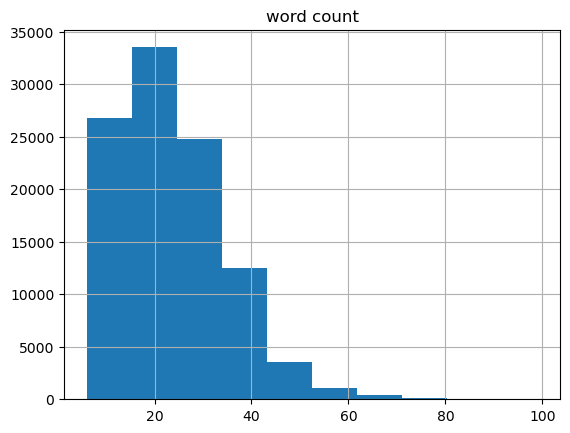

In [351]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df_article.hist(column = 'word count')

In [352]:
df_article.to_csv('C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\article_sentences_gnews.csv', index = False)

In [340]:
df_article.isnull().sum()

doc_type      0
company       0
sentence      0
word count    0
dtype: int64